In [14]:
import fit_classes as fp
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# NOTE: Cosntants defining:

PH_TARGET = 4.40

PH_ACTUAL = 4.41
PH_ACTUAL_PLUS_NAOH = 4.69
PH_ACTUAL_PLUS_HCL = 3.72

VOL = 0.100 # L
VOL_CH3COOH = 0.390 # mL
VOL_CH3COONA = 0.26 # mL

MOLAIR_NAOH = 0.1 # mol/L
MOLAIR_HCL = 0.1 # mol/L
MOLAIR_AZIJNZUUR = 60 # g/mol

# NOTE: Titratie:
x = np.array([0, 1.2, 2.2, 3, 4, 5.1, 6, 7, 7.5, 8, 8.5, 9.1, 9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13.1, 14, 15.2, 16, 17, 18, 19, 20])
dx = 0.05*np.ones_like(x)
y = np.array([3.18, 3.80, 4.13, 4.33, 4.53, 4.72, 4.88, 5.09, 5.21, 5.38, 5.51, 5.59, 5.72, 6.2, 9.66, 11.02, 11.28, 11.45, 11.57, 11.69, 11.79, 11.90, 11.97, 12.03, 12.07, 12.12, 12.15])
dy = 0.005*np.ones_like(y)

# Deel 1

In [15]:
Dstof_HCl = 0.002*MOLAIR_HCL
DpH_HCl = PH_ACTUAL_PLUS_HCL - PH_ACTUAL

Dstof_NaOH = 0.002*MOLAIR_NAOH
DpH_NaOH = PH_ACTUAL_PLUS_NAOH - PH_ACTUAL

pi_HCl = -(Dstof_HCl)/(DpH_HCl*VOL) # mol/L
pi_NaOH = (Dstof_NaOH)/(DpH_NaOH*VOL) # mol/L
print("Buffercapaciteit \pi voor 2mL (xx mol) HCl toevoegen aan 100mL buffer:", pi_HCl)
print("Buffercapaciteit \pi voor 2mL (xx mol) NaOH toevoegen aan 100mL buffer:", pi_NaOH)

Buffercapaciteit \pi voor 2mL (xx mol) HCl toevoegen aan 100mL buffer: 0.0028985507246376816
Buffercapaciteit \pi voor 2mL (xx mol) NaOH toevoegen aan 100mL buffer: 0.0071428571428571366


# Deel 2

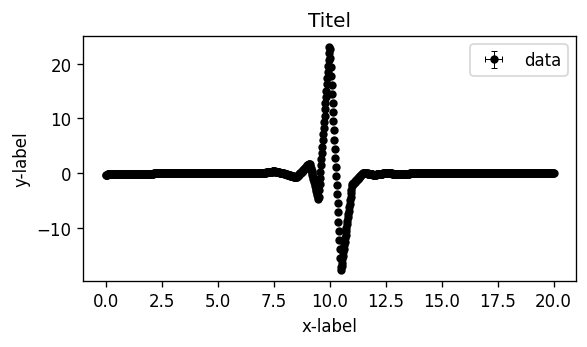

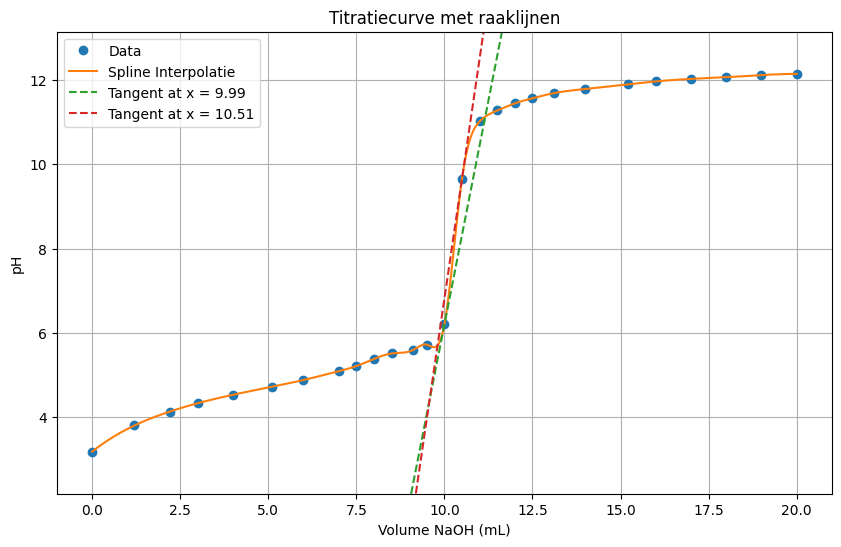

In [16]:
# Deel 2

# Raaklijnen plotten
spline = CubicSpline(x, y)
x_fine = np.linspace(min(x), max(x), 1000)
y_fine = spline(x_fine)
d2_spline = spline.derivative(nu=2)
d2_y = d2_spline(x_fine)

fp.Data(x_fine, d2_y, np.zeros_like(y_fine)).show()

min_index = np.argmin(d2_y)
max_index = np.argmax(d2_y)
min_x = x_fine[min_index]
max_x = x_fine[max_index]
slope_min = spline.derivative()(min_x)
slope_max = spline.derivative()(max_x)
intercept_min = spline(min_x) - slope_min * min_x
intercept_max = spline(max_x) - slope_max * max_x

plt.figure(figsize=(10, 6))
# Plot the data and the spline interpolation
plt.plot(x, y, 'o', label='Data')
plt.plot(x_fine, y_fine, label='Spline Interpolatie')

# Plot the tangent lines at the knikpunten
plt.plot(x_fine, slope_max * x_fine + intercept_max, '--', label=f'Tangent at x = {max_x:.2f}')
plt.plot(x_fine, slope_min * x_fine + intercept_min, '--', label=f'Tangent at x = {min_x:.2f}')

plt.xlim(min(x) - 1, max(x) + 1)
plt.ylim(min(y) - 1, max(y) + 1)

plt.xlabel('Volume NaOH (mL)')
plt.ylabel('pH')
plt.legend()
plt.grid()
plt.title('Titratiecurve met raaklijnen')
plt.show()


Equivalentiepunt bij volume: 10.51051051051051
Fout op equivalentiepunt: 0.05
Afgelezen pKa: 4.746297664141681


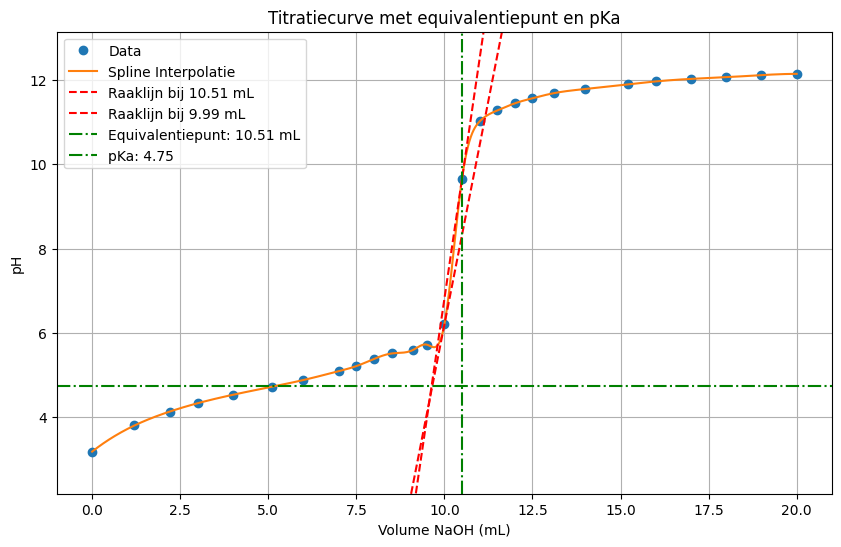

In [26]:
# Raaklijnen plotten
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', label='Data')
plt.plot(x_fine, y_fine, label='Spline Interpolatie')

knikpunten = [x_fine[min_index], x_fine[max_index]]

for kp in knikpunten:
    slope = spline.derivative()(kp)
    intercept = spline(kp) - slope * kp
    plt.plot(x_fine, slope * x_fine + intercept,  linestyle='--', color='red', label=f'Raaklijn bij {kp:.2f} mL')

# plt.xlabel('Volume NaOH (mL)')
# plt.ylabel('pH')
# plt.legend()
# plt.grid()
# plt.title('Titratiecurve met raaklijnen')
# plt.show()

# Equivalentiepunt vinden
def verschil_oppervlakten(x_pos):
    rechte = slope * x_fine + intercept
    boven = np.trapezoid(y_fine[y_fine >= rechte], x_fine[y_fine >= rechte])
    onder = np.trapezoid(y_fine[y_fine < rechte], x_fine[y_fine < rechte])
    return abs(boven - onder)

res = minimize(verschil_oppervlakten, x0=knikpunten[0], bounds=[(min(x), max(x))])
V_eq = res.x[0]
print("Equivalentiepunt bij volume:", V_eq)

# Fout op equivalentiepunt
D_Veq = 0.05  # Schatting van fout door aflezing
print("Fout op equivalentiepunt:", D_Veq) 

# pKa bepalen
half_eq = V_eq / 2
pKa = spline(half_eq)
print("Afgelezen pKa:", pKa) 

# Visualisatie
# plt.figure(figsize=(10, 6))
# plt.plot(x, y, 'o', label='Data')
# plt.plot(x_fine, y_fine, label='Spline Interpolatie')
plt.axvline(V_eq, linestyle='-.', color='green', label=f'Equivalentiepunt: {V_eq:.2f} mL')
plt.axhline(pKa, linestyle='-.', color='green', label=f'pKa: {pKa:.2f}')
plt.xlim(min(x_fine) - 1, max(x_fine) + 1)
plt.ylim(min(y_fine) - 1, max(y_fine) + 1)
plt.xlabel('Volume NaOH (mL)')
plt.ylabel('pH')
plt.legend()
plt.grid()
plt.title('Titratiecurve met equivalentiepunt en pKa')
plt.show()
